<h1>Hands On: Unsupervised Learning Techniques.</h1>

Aunque muchos de los problemas de ML se resuelven con algoritmos supervisados, la mayor parte de los datos que existen no están etiquetados (labeled). Cuando no existe una etiqueta para el dato, se utilizan algoritmos no supervisados. En este notebook vamos a ver algunos de los algoritmos no supervisados más importantes:

  - Clustering.
  - K-Means. Límites del K-Means.
  - Uso de Clustering para segmentación de imágenes, preprocesamiento y entrenamiento semi-supervisado.
  - DBSCAN y otros algoritmos de clustering. 
  - Gaussian Mixtures.
  - Anomaly Detection usando Gaussian Mixtures. Seleccionando el número de Clusters.
  - Bayesian Gaussian Mixture.
  - Otros algoritmos de Anomaly Detection y Novelty Detection.
  
Existen tres grupos de algoritmos no supervisados: los de Clustering, que agrupan las instancias en clusters o grupos; los de Anomaly Detection, que detectan instancias que no son "normales" dentro del set; y los de Density Estimation, que estiman la probability density function (PDF) de los procesos random que generan el dataset. 

En este notebook se estudiarán todos ellos y sus usos e implicaciones.

<h3>Imports</h3>

In [10]:
# Imports generales:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import urllib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.image import imread
from sklearn.datasets import load_digits
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_moons
from matplotlib.colors import LogNorm

# Algoritmos:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

# Para esconder los warning:
import warnings
warnings.filterwarnings('ignore')

<h2>Clustering</h2>

Clustering es el acto de agrupar distintas instances o objetos en grupos (o clusters) en función de sus carácteristicas, sin que la etiqueta sea un factor a tener en cuenta. Por ejemplo, se pueden agrupar los visitantes de una web o servicio (por ejemplo, youtube) en función de ciertos rasgos (edad, genero, etc), y así asignar nuevo contenido. Los grupos creados serán los clusters.

En cierto modo, es similar al proceso de clasificación visto en notebooks anteriores, salvo que no se necesita conocer la etiqueta de cada instance (es decir, no necesitamos la etiqueta al grupo), solo agrupar aquellos que son iguales entre si y distintos al resto.

El clustering es útil para un amplio grupo de aplicaciones, por ejemplo:

 - Agrupación y segmentación de clientes, de cara a adaptar tus productos, servicios y marketing para tener mayor impacto.
 - Análisis de datos: ya que un primer estudio de los datos puede permitir separaciones de clusters para tratamiento individual.
 - Como técnica de reducción de dimensionalidad: Una vez clusterizado el dataset, es posible medir la afinidad de cada instancia con cada cluster. Sustituir el vector de cada instancia por este vector de afinidades del mismo con los clusters suele resultar en una disminución de dimensión, preservando información suficiente.
 - Anomaly Detection: también llamado Outlier Detection o detección de atípicos. Encontrar aquellas instancias que tengan una baja afinidad con todos los clusters es una forma sencilla de encontrar los atípicos. La detección de atípicos es particularmente útil en los controles de calidad de fabricación o la detección de fraude.
 - Entrenamiento Semi-supervisado: en el caso de tener un dataset con unos pocos registros etiquetados, es posible clusterizar el dataset y extender las etiquetas al resto de instancias del mismo cluster. Esto puede mejorar sustancialmente la cantidad de instances con etiqueta, lo que repercute en un mejor performance del modelo.
 - Motores de búsqueda: por ejemplo, algunos motores de búsqueda te permiten encontrar imágenes que son similares a una que estás buscando. Para conseguir esto, es necesario aplicar un clustering a las imagenes. Después sólo hace falta mostrar aquellas imágenes que estén en el mismo clúster que la buscada.
 - Para segmentación de imágenes: clusterizar píxeles en funcion de su color, y sustituir cada uno por el promedio del cluster es una técnica util para reducir la gama de colores de una foto de forma considerable. Esta técnica se usa en detección de objetis y sistemas de tracking, haciendo más sencillo encontrar el contorno de cada objeto.
 
No existe una definición universal de lo que es un cluster, ya que en cada contexto y cada algoritmo lo interpreta a su manera. A continuación veremos dos ejemplos de algoritmos de clustering muy populares: el K-Means y el DBSCAN, y estudiaremos sus aplicaciones.

<h2>K-Means. Límites del K-Means.</h2>

El K-Means es un algoritmo simple capaz de clusterizar datasets de una forma rápida, eficiente, sencilla y en muy pocas iteraciones. 

Vamos a ver gráficamente un ejemplo, y después explicamos el algoritmo:

Los datos son los siguientes: 


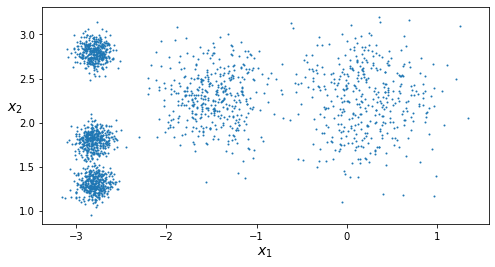

Los centroides son: 
[[-2.80389616  1.80117999]
 [ 0.20876306  2.25551336]
 [-2.79290307  2.79641063]
 [-1.46679593  2.28585348]
 [-2.80037642  1.30082566]]
Las labels son: 
[4 0 1 ... 2 1 0]
La predicción sobre las instancias de X_new es: 
[1 1 2 2]

Diagrama de Voronoi de los clusters creados: 


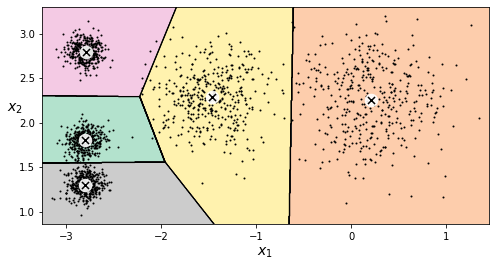

In [2]:
# Creamos un dataset de blob's centers:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

# Los pintamos:
print ('Los datos son los siguientes: ')
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

# Creamos un K-Means y fitteamos y predecimos:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

# Se puede obtener información sobre los centros de los clusters (centroides), las labels, etc:

print ('Los centroides son: ')
print (kmeans.cluster_centers_)

print ('Las labels son: ')
print(kmeans.labels_)

# Por supuesto, también se puede predecir sobre nuevas instancias:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
print('La predicción sobre las instancias de X_new es: ')
print(kmeans.predict(X_new))


# Y. gráficamente, los clústers serán (en un diagrama de Voronoi):
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        
        
print('')
print('Diagrama de Voronoi de los clusters creados: ')
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()


Explicando el ejemplo de antes: 
    1. Se han creado unos datos "random" pero agrupados en torno a 5 puntos o centroides teóricos. 
    2. Se ha seleccionado el número de centroides que se quieren en el k-means. En este caso, 5.
    3. Al entrenar el K-Means, se ha asignado a cada instance del dataset un centroide, es decir, una etiqueta del 1 al 5. Esto es distinto a las labels del dataset, y de hecho las labels se preservan en el atributo labels_ del kmeans.
    4. Además de asignar a cada instancia un cluster, el K-Means estima el centroide de esos clusters. Esto es accesible mediante el atributo cluster_labels_. Como se observa, son similares a los del punto 1.
    5. Una vez entrenado el K-Means, es posible predecir sobre nuevas instancias, asignándoles un cluster.
    6. Por último, se ha graficado el resultado usando un Voronoi Tessellation, o diagrama de Voronoi, que estima las decision boundaries de cada cluster por medio de bisectrices.
    
Una característica de K-Means es que no funciona muy bien cuando los grupos tienen distintos diámetros, porque en lo único que se fija al asignar un cluster a una instancia es la distancia al centroide. Por eso, en el ejemplo, se ve como entre los centroides rosa y amarillo existen instances mal asignadas.

El proceso en el que se asigna un único centroide a cada instance es el llamado "hard clustering". Si en lugar de eso se asigna una puntuación por cluster es el llamado "soft clustering". Por ejemplo se utiliza como score la distancia al cluster (o algo similar). En la clase KMeans existe el método transform() que hace eso. Esta técnica es un método de reducción de dimensionalidad bastante útil para datasets de muchas dimensiones. Un ejemplo de uso con el vector X_new de antes:

In [3]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

Una vez visto un ejemplo, ¿cómo funciona realmente el K-Means? 

Si te diesen los centroides, sería tan simple como asignar a cada instancia el centroide más cercano. Si te diesen las labels, se calcularía el centroide computando el promedio de las instancias de cada cluster. Pero normalmente no te dan ni labels ni centroides. 

Si no te dan nada, se inicia ubicando los centroides de forma aleatoria. Sobre estos centroides, se asignan los clusters a las instancias y se recalculan los centroides con el promedio de las instances de cada uno. Este proceso se repite hasta que los centroides dejan de moverse. Este proceso siempre converge y suele ser muy rápido, pero no siempre tiende hacia la solución óptima (puede encontrar mínimos locales). Por ello existen mejores opciones a la hora de elegir los centroides que la simple inicialización aleatoria.

Un ejemplo de cómo puede influir la inicialización de los centroides a la hora de definir los clusters es el siguiente:

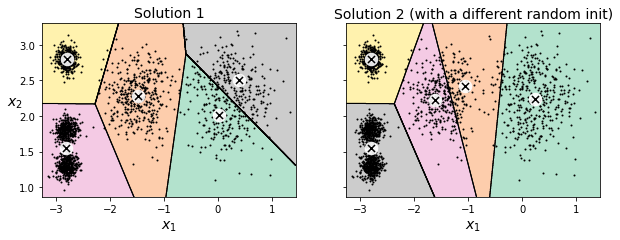

In [4]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)
        
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

En Sklearn existen métodos de elegir los centroides. Por ejemplo, se pueden establecer los centroides exactos con los que quieras iniciar el algoritmo usando el parámetro init de la clase KMeans. 

Otra forma de minimizar la posibilidad de error en la elección de centroides es mediante el parámetro n_init. Este parámetro define el número de veces que se ejecuta el algoritmo. Sobre las n_init ejecuciones, se elige como válida aquella que tenga un valor menor de "inertia". La "inertia" es la mean squared distance entre cada instancia y el centroide más cercano. Es accesible mediante el atributo inertia_. Además, el método score() devuelve la inertia con símbolo negativo, porque los scores tienen como criterio "great is better". Ejemplo:

La inertia del Solution 1 es:  223.29108572819035
La inertia del Solution 2 es:  237.46249169442845

Solución del mejor algoritmo de los 10 intentados:


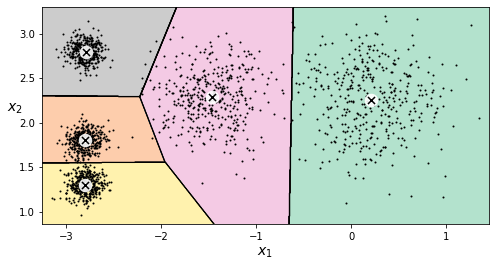

La inertia del KMeans eligiendo los centroides es:  211.5985372581684

Y gráficamente es:


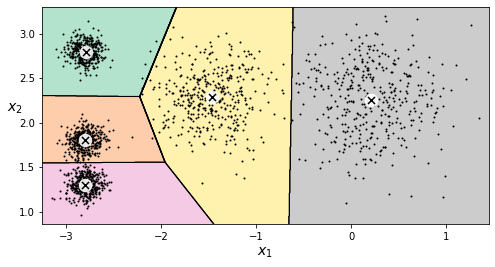

In [5]:
print('La inertia del Solution 1 es: ',kmeans_rnd_init1.inertia_)
print('La inertia del Solution 2 es: ',kmeans_rnd_init2.inertia_)

# Ejemplo de inicialización de 10 kmeans (10 también es el valor por defecto)
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

print('')
print('Solución del mejor algoritmo de los 10 intentados:')
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()


# Ejemplo de KMeans entrenado eligiendo los centroides al inicio:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
print( 'La inertia del KMeans eligiendo los centroides es: ',kmeans.inertia_)
print('')
print('Y gráficamente es:')
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()


En 2006 se publicó una mejora del algoritmo llamada "K-Means++", que introduce una inicialización de los centroides con mucha menor probabilidad de convergencia en mínimos locales. En concepto, este algoritmo tiende a seleccionar centroides que están distantes entre si. El algorítmo tiene los siguientes pasos:

    1- Se coge un centroide c(1), elegido de forma aleatoria del dataset.
    2- Se coge un nuevo centroide c(i) a distancia x(i) con probabilidad D(x(i))² = sum((x(j)²), donde D(x(i)) es la distancia entre x(i) y el centroide mas cercano que ya se haya elegido. Esta distribución de probabilidad asegura que las instancias más alejadas de los centroides que ya se han elegido son mucho mas propensas a ser elegidas como nuevos centroides.
    3- Se repite el paso anterior hasta que se han elegido los k centroides.
    
La clase KMeans de Sklearn usa esta inicialización por defecto. Si quieres usar el método original hay que definir el hiperparámetro init="random". No se suele hacer.

Existen otras mejoras importantes sobre el algoritmo de K-Means. Otra fue propuesta en 2003, y es llamada "Accelerated K-Means". Consiste en una aceleración del algoritmo al evitar el cálculo de muchas distancias que realmente no son necesarias de calcular. Es el algoritmo usado por defecto por la clase KMeans (pero se puede usar el algoritmo original forzando el hiperparámetro algoritm='full').

Otra mejora es el Mini-batch K-Means, que permite entrenar con K-Means cuando el dataset es demasiado grande como para cargarlo en memoria, y suele acelerar el algoritmo en un factor 3-4 normalmente. Existen varias formas de hacer un Mini-Batch K-Means en función del tamaño de los datos. Las vemos a continuación:

In [6]:
# 1er ejemplo: SKlearn incluye una clase MiniBatchKMeans:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)
print('Inertia del MiniBatchKMeans:',minibatch_kmeans.inertia_)

# 2o ejemplo: Si el dataset no cabe en memoria, se puede usar memmap:
  # Cargamos el MNIST
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

  # Separamos en train y test: 
X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

  # Escribimos en un memmap: 
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

  # Entrenamos el MiniBatchKMeans:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)


# 3er ejemplo: Si el dataset es taaan grande que ni siquiera se puede hacer un memmap, se hacen los batches a mano:

def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

np.random.seed(42)

k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans
        
print('El score del mejor KMeans haciendo los batches manuales es:',best_kmeans.score(X))

Inertia del MiniBatchKMeans: 211.93186531476775
El score del mejor KMeans haciendo los batches manuales es: -211.70999744411483


El siguiente problema que nos encontramos es estimar el número correcto de clusters. En los ejemplos de antes era bastante obvio que el número era 5 (porque habiamos creado nosotros los datos), pero lo normal es no saber cuál es el número óptimo. 

Se podría pensar que la forma más sencilla de elegir el número de clusters es coger aquel que tenga menor inertia. Sin embargo esto no puede hacerse porque cuantos más centroides se pongan, menor es la inertia del modelo. La forma típica es buscar el codo de la función de la inertia en función del número de clusters. 

Veamos un ejemplo de mala elección de clusters, y otro de la función inertia/nº clusters:

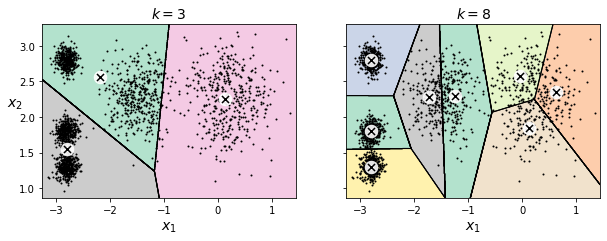

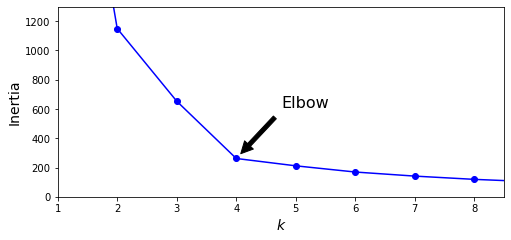

In [7]:
# Ejemplo de mala selección de clusters:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

# Ejemplo de función y codo:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

Se ve, en el ejemplo, que el codo lo hace en k=4. Si no tuviesemos información extra, sería una muy buena opción. Cualquier valor mayor no ayudaría mucho, y cualquiera menor sería muy malo.

Existe una forma mejor (aunque computacionalmente más costosa) de calcular el número óptimo de clusters. Es el "Silhouette score", que es el promedio del "silhouette score" en todas las instancias. El "silhouette score" de una instancia viene dado por (b-a)/max(a,b) , donde a es la distancia promedio a las otras instancias del mismo cluster, y b es la distancia promedio de las instancias del cluster más cercano (que no sea el suyo).

El coeficiente "silhouette" varía entre -1 y 1, siendo 1 el caso en el que las instancias están muy agrupadas en su cluster, y muy alejadas del resto; y -1 el caso en el que la instancia está en un cluster mal asignado.

Existe una función para calcular el "silhouette score" en Sklearn: silhouette_score(). Ejemplo:

Ejemplo de silhouette score:  0.655517642572828

Silhouette score en función del número de clústers:


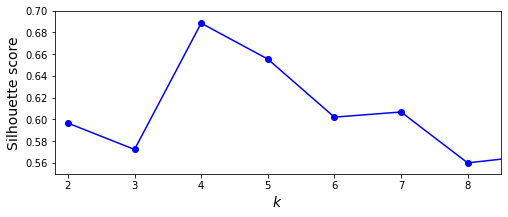

In [8]:
print('Ejemplo de silhouette score: ',silhouette_score(X, kmeans.labels_))

# Vamos a ver el silhouette score para los distintos k:
print('')
print('Silhouette score en función del número de clústers:')

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

Como se ve, esta forma de estudiarlo es mucho más útil. Se confirma que k=4 era una muy buena opción, y también confirma que k=5 es mucho mejor que 6,7 o 8. Esto no se veía en inertias.

Otra forma todavia mejor es plottear el "silhouette coefficient" de cada cluster en cada k:

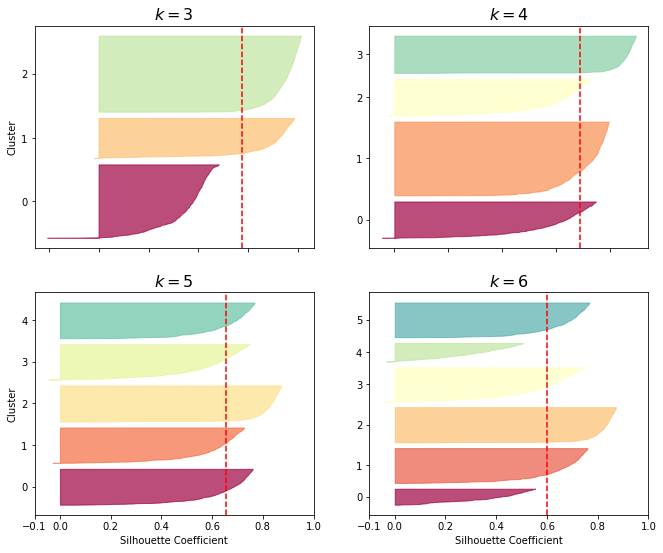

In [9]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Al tener una idea de cada cluster, se pueden sacar mas conclusiones. La linea discontinua representa el valor de "silhouette score" para ese k en concreto. Así se ve que k=3 y k=6 tienen algunos clusters que, en comparación, son muy malos. La duda entre el 4 y el 5 sigue siendo razonable. El 4 tiene un cluster muy bueno y 3 no tan buenos, pero el 5 tiene clusters muy similares. Además, el cluster 1 de k=4 contiene muchas mas instancias que el resto, mientras que en el k=5 están balanceados. Ambas opciones son muy buenas, pero es más interesante el k=5 (aunque ya lo sabiamos, estabamos buscando la confirmación solo). 

<h3>Límites del K-Means</h3>

Para finalizar con el K-Means, debemos estudiar sus límites. 

El primero, es que se debe ejecutar varias veces para intentar evitar los mínimos locales en lugar de la mejor solución. 

Además, K-Means no funciona muy bien cuando existen clusters de distintos tamaños, densidades o no son esféricos. Para sets con formas distintas es mejor usar otros algoritmos, como Gaussian Mixture (se ve después).

Por último, es importante escalar los datos antes de ejecutar K-Means, si no se hace funciona fatal. Esto tampoco asegura que todo vaya a salir genial, pero mejora muchisimo los resultados.

Vamos a ver un ejemplo de K-Means fallando mucho:

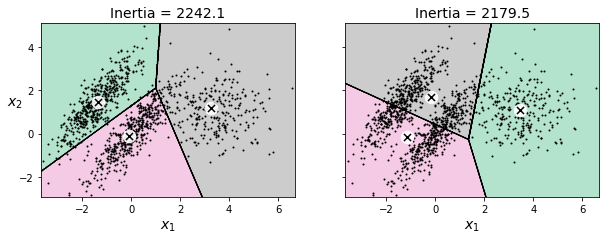

In [10]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)


plt.show()

El caso de la izquierda falla un 25% de las veces en el cluster central. El de la derecha es terrible, y aun así da un menor momento de inertia que el primero.

<h2>Uso de Clustering para segmentación de imágenes, preprocesamiento y entrenamiento semi-supervisado.</h2>

<h3>Uso de Clustering para segmentación de imágenes</h3>

Image Segmentation es la tarea de descomponer una imagen en múltiples segmentos o elementos. Por ejemplo, en un sistema de coche autónomo, todos los píxeles que correspondan a un peatón se asociarán al segmento "peatón". En Instance Segmentation, todos los píxeles que corresponden al mismo objeto individual serán asignados al mismo segmento. Así habrá un segmento para cada peatón. El State of the Art de estas tareas se consigue con arquitecturas complejas de redes neuronales convolucionales, pero vamos a estudiarlo de forma mucho más sencilla: con un color segmentation.

Para hacer un color segmentation simplemente vamos a asignar pixeles de color similar al mismo segmento. Vamos a ver cómo se haría:

Las dimensiones de la imagen son:  (533, 800, 3)
Es un array de 3D porque es alto, ancho y canales. Los 3 canales son Red, Green y Blue (en ese orden)


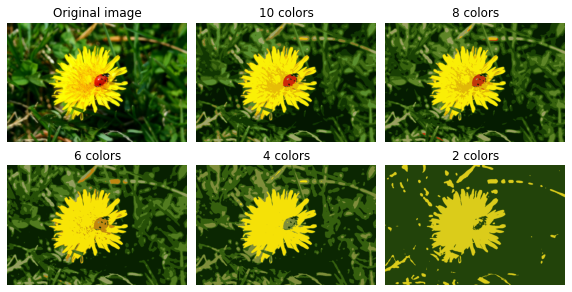

In [11]:
# Descargamos las imagenes de muestra
PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

# Vamos a ver qué tamaño tiene la imagen:
image = imread(os.path.join(images_path, filename))
print('Las dimensiones de la imagen son: ',image.shape)
print('Es un array de 3D porque es alto, ancho y canales. Los 3 canales son Red, Green y Blue (en ese orden)')

# Las imágenes vendrán en 3 matrices con valores entre 0.0 y 1.0 (o 0 y 255 si se abre con imageio.imread())

# El siguiente código reagrupa el array para tener una lista de los colores de RGB, y los clusteriza usando un 
# K-Means. Después, para cada color, busca por el promedio de colores del cluster. Por último reagrupa la lista de
# colores para tener el mismo shape que el original:


X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)


# Si experimentamos con distinto número de clusters, tenemos el siguiente resultado:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))
    

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

<h3>Uso de Clustering para Preprocesamiento</h3>

El clustering puede ser una forma eficiente de reducir dimensiones de cara a preprocesar antes de entrenar un algoritmo. 

Vamos a ver un ejemplo con el MNIST:

In [12]:
# Primero importamos el MNIST:
X_digits, y_digits = load_digits(return_X_y=True)

# Vamos a generar un training y un test sets:
X_train, X_test, y_train, y_test = train_test_split(X_digits,y_digits, random_state = 42)

# Para tener un modelo base, vamos a entrenar un logistic regression:

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train,y_train)
print('El score del modelo base es: ',log_reg.score(X_test,y_test))

# Ahora vamos a intentar mejorarlo usando un k-means en el preprocessing: para ello vamos a hacer primero un 
# clustering en 50 grupos, y despues reeemplazar las imágenes por las distancias a esos 50 grupos y hacer el logreg

pipeline = Pipeline([
    ('kmeans',KMeans(n_clusters=50, random_state=42)),
    ('log_reg',LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))
])
pipeline.fit(X_train,y_train)
print('El score del modelo con preprocessing es: ',pipeline.score(X_test,y_test))

# Y esto ha sido eligiendo el número de clusters de forma arbitraria. Vamos a probar a añadir un GridSearchCV
# para encontrar el número idóneo de clusters

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3)
grid_clf.fit(X_train,y_train)
print('El mejor valor para el número de clusters es: ',grid_clf.best_params_)
print('Y el score que da es: ',grid_clf.score(X_test,y_test))

El score del modelo base es:  0.9688888888888889
El score del modelo con preprocessing es:  0.9777777777777777
El mejor valor para el número de clusters es:  {'kmeans__n_clusters': 99}
Y el score que da es:  0.98


<h3>Uso de Clustering para aprendizaje Semi-Supervisado</h3>

Otro ejemplo de uso del clustering es en aprendizaje semi-supervisado. Vamos a ver un ejemplo en un subset del MNIST:

El score del modelo base es:  0.8333333333333334


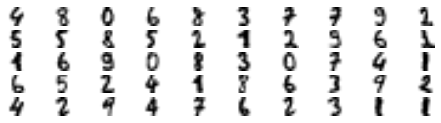

El score del modelo con los 50 digitos mas representativos es:  0.9222222222222223
El score del modelo con el label propagado es:  0.9333333333333333
El score del modelo con el label propagado al 20% es:  0.94


In [13]:
# Ponemos, por ejemplo, 50 instances y entrenamos un modelo baseline:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
print('El score del modelo base es: ',log_reg.score(X_test, y_test))

# La accuracy es baja porque solo tenemos 50 instances.

# Vamos a agrupar el training set en 50 clusters y a etiquetar solo los dígitos mas representativos (los mas 
# cercanos a los centroides)

k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

# Ponemos las etiquetas a manita:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

# Y entrenamos solo con estos 50 digitos. Veamos si es mejor que el baseline:

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
print('El score del modelo con los 50 digitos mas representativos es: ',log_reg.score(X_test, y_test))


# Un paso mas alla. Vamos a hacer label propagation para todas las instancias, asignando el label que hemos puesto
# a cada digito representativo para todos los del mismo cluster:

y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
    
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
print('El score del modelo con el label propagado es: ',log_reg.score(X_test, y_test))

# Es facil que estemos asignando mal los labels a los elementos mas alejados de sus centroides. Vamos a ver si 
# mejora si solo nos quedamos el 20% de las instancias (el 20% más cercano al centroide):

percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

print('El score del modelo con el label propagado al 20% es: ',log_reg.score(X_test, y_test))

# Para habernos "inventado" los labels esta genial un 94%, comparado con el baseline de los originales (96,7%)

Existe un concepto de mejora de rendimiento en los aprendizajes Semi-Supervisados que es el Active Learning. Esto es la interacción de humanos con el algoritmo cuando este lo necesita. Existen muchas estrategias diferentes, pero una de las más usada (y la que vamos a ver) es Uncertainty Sampling:

 - Primero: Se entrena el modelo como se ha hecho, y se usa para hacer predicciones sobre las instances a las que no se les ha asignado label.
 - Se cogen aquellas instances en las que el modelo tiene menos certeza (p.e. cuando la probabilidad estimada es baja) y se etiquetan por expertos.
 - Se repite este proceso hasta que las mejoras producidas no compensan el esfuerzo empleado.
 
Otras estrategias son etiquetar instances que provoquen un cambio grande en el modelo, o que quiten la mayor parte del error de validacion, o aquellas en las que distintos modelos no coincidan.

<h2>DBSCAN y otros algoritmos de clustering</h2>

<h3>DBSCAN</h3>

Este algoritmo define los clusters como regiones continuas de alta densidad, tal que así:

    - Para cada instancia, se cuentan las instancias que haya a una distancia epsilon, llamados e-neighborhood.
    - Si una instancia tiene, por lo menos, min_samples instacias en su e-neighborhood se la considera core instance. Las core instances son aquellas que estan ubicadas en regiones densas.
    - Todas las instancias en el neighborhood de una core instance pertenecen al mismo cluster. Puede contener oras core instances, formando estas y sus e-neighbors un mismo cluster.
    - Cualquier instancia que no es core instance y no esta en un cluster es considerada un outlier.
    
Este algoritmo funciona bien si los clusters son densos y estan separados por zonas poco densas. En Sklearn funciona así:

Las labels de las 10 primeras instances son:  [ 0  2 -1 -1  1  0  0  0  2  5]
El total de core instances es:  808
Los diez primeros índices core instances:  [ 0  4  5  6  7  8 10 11 12 13]
Y sus posiciones son:  [[-0.02137124  0.40618608]
 [-0.84192557  0.53058695]
 [ 0.58930337 -0.32137599]
 [ 0.29248724 -0.20696309]
 [-0.02637836  0.44766267]
 [ 1.6201408  -0.28758856]
 [ 1.26718285 -0.40793471]
 [ 0.87418608  0.50781041]
 [ 0.3322007  -0.19032202]
 [ 1.952812    0.22552333]]


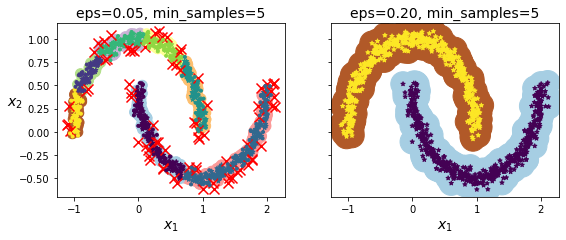

In [14]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
# A las labels se accede asi:
print('Las labels de las 10 primeras instances son: ', dbscan.labels_[:10])
# Las instances con label -1 son los atípicos
# Además se puede acceder a otras cosas:
print('El total de core instances es: ', len(dbscan.core_sample_indices_))
print('Los diez primeros índices core instances: ',dbscan.core_sample_indices_[0:10])
print('Y sus posiciones son: ',dbscan.components_[0:10])

# Vamos a ver como quedan ese ejemplo y uno de epsilon=0.2 (porque sale mejor):
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)


def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)
    
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

Sin embargo, el DBSCAN no tiene un método predict (aunque si un fit_predict). El motivo es que existen varios algoritmos que tendrían sentido aqui, y es facil entrenar uno, asi que a hacerlo:

El predict del array nuevo:  [1 0 1 0]
Y tambien hay predict_proba:  [[0.18 0.82]
 [1.   0.  ]
 [0.12 0.88]
 [1.   0.  ]]


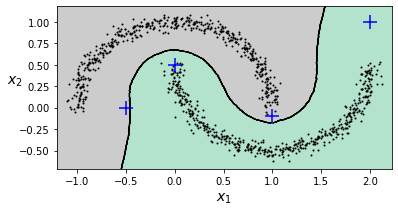

Las etiquetas son:  [-1  0  1 -1]


In [25]:
dbscan = dbscan2
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

# Esto ya si predice:

X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
print('El predict del array nuevo: ',knn.predict(X_new))
print('Y tambien hay predict_proba: ',knn.predict_proba(X_new))

# Queda tal que así:

plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

# Y se podrían definir los atípicos poniendo la distancia epsilon sobre lo predicho:

y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1) # Este método devuelve la distancia y los indices de los 
# k-nearest-neighbors en el set
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
print('Las etiquetas son: ',y_pred.ravel())

En definitiva, DBSCAN es muy potente y capaz de calcular cualquier número de clusters de cualquier forma. Su problema es cuando las densidades de los clusters varían significantemente. Además tiene una complejidad computacional cercana a lineal cuando el número de instancias es alto (O(m*log(m))) y requiere bastante memoria si epsilon es grande (O(m²))

<h3>Otros algoritmos de clustering</h3>

Sklearn implementa otros algoritmos de clustering que también son interesantes. Algunos ejemplos son:

    - Agglomerative clustering: La jerarquía de clusters se construye de abajo a arriba. Gráficamente, sería como gotas de agua que se van uniendo entre si formando gotas más grandes. En cada iteración el algoritmo conecta el par de clusters más cercano. Esto permite crear un binary tree of clusters. Este algoritmo es muy escalable, flexible, captura clusters de muchas formas y no depende de distancias ni densidades. El problema es que para escalar correctamente, necesita una matriz de conectividad. Esta es una matriz que indica los pares de neighbors (y que es devuelta por sklearn.neighbors.kneighbors_graph())
    - Birch: Este algoritmo está desarrollado para datasets muy grandes, y es más rápido que el batch K-Means y con idénticos resultados siempre que el número de features no sea muy grande (<20). Genera una estructura tipo arbol que contiene la información necesaria para asignar las nuevas instancias a un cluster, sin guardar las instancias en el árbol.
    - Mean-shift: Comienza colocando un círculo centrado en cada instancia, computa el promedio de las instancias colocadas en el y mueve el círculo al promedio. Repite este proceso hasta que ya no se mueven los círculos, y junta aquellos círculos que caen en el mismo sitio (o suficientemente cerca). Tiene características similares a DBSCAN, ya que encuentra cualquier número de clusters de cualquier tamaño, sólo tiene un hiperparámetro (el radio del círculo, bandwidth) y depende de las densidades internas. Su problema es que tiende a dejar instancias como clusters si tiene variaciones de densidad internas, y que escala mal para datasets grandes (complejidad O(m²))
    - Affinity propagation: Usa un sistema de votacion, donde cada instancia vota a sus "similares" para ser representativas, y cuando el algoritmo converge cada representante y sus votantes forman un cluster. Detecta cualquier forma y tamaño de clusters pero escala mal (O(m²)).
    - Spectral clustering: Construye una similarity matrix entre las instancias y crea un low-dimensional embedding para ello (reduce dimensionalidad). Después utiliza otro algoritmo para clusterizar (en Sklearn es K-Means). Sus características son que captura estructuras complejas, es útil para cut-graphs (p.e. identificar clusters de amigos en redes sociales), pero no escala bien para muchas instances y se comporta regular cuando los clusters difieren en tamaños.

<h2>Gaussian Mixtures</h2>

Un modelo Gaussian Mixture es un modelo probabilístico cuya premisa inicial es que la muestra se ha generado por la unión de distribuciones Gaussianas con parámetros desconocidos. Todas las instances generadas por una misma distribución Gaussiana constituyen un mismo cluster. Estos clusters pueden ser distintos en tamaño, densidad y orientación. Sin embargo, siempre tienen forma elipsoidal.

Existen distintas variantes del GMM. La mas simple (implementada en la clase GaussianMixture) te pide saber el numero k de distribuciones Gaussianas. Entonces se asume que el dataset se ha generado tal que cada instancia se asigna a un cluster j con una probabilidad phi(j), y dentro del cluster se distribuye de forma aleatoria pero con distribución Gaussiana de media mu(j) y covarianza Epsilon(j). Resumiendo, cada instancia se ha asignado a un cluster j, con una probabilidad de ser elegido phi(j) y dentro se distribuye en Gaussiano.

Esto nos permite, dado un dataset X, intentar estimar los pesos phi y los parámetros de distribucion mu y Epsilon de cada cluster. Ejemplo en Sklearn:

Los pesos de los clusters:  [0.20965228 0.4000662  0.39028152]
Los valores de los mu:  [[ 3.39909717  1.05933727]
 [-1.40763984  1.42710194]
 [ 0.05135313  0.07524095]]
Los Epsilon (covarianzas):  [[[ 1.14807234 -0.03270354]
  [-0.03270354  0.95496237]]

 [[ 0.63478101  0.72969804]
  [ 0.72969804  1.1609872 ]]

 [[ 0.68809572  0.79608475]
  [ 0.79608475  1.21234145]]]
¿El algoritmo ha convergido?:  True
¿En cuantos pasos ha convergido?:  4
¿El log de la probability density function de las 3 primeras instances?:  [-2.60782346 -3.57106041 -3.33003479]
La probabilidad de que haya instancias entre -10 y 10:  0.9999999999217849

La predicción de las 3 primeras instances:  [2 2 1]
El predict_proba de las 3 primeras instances:  [[2.32389467e-02 6.77397850e-07 9.76760376e-01]
 [1.64685609e-02 6.75361303e-04 9.82856078e-01]
 [2.01535333e-06 9.99923053e-01 7.49319577e-05]]

Las dos instancias creadas por el modelo:  [[-0.86949155 -0.32757903]
 [ 0.29841759  0.28297897]]
En el cluster:  [2 2]

Lo

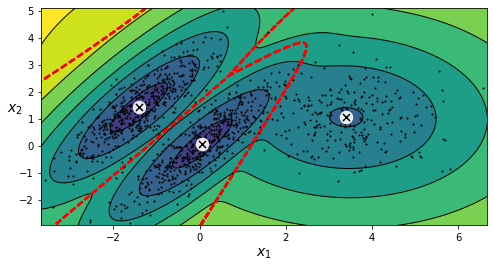

In [3]:
# Generamos el dataset:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

# Entrenamos el modelo:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

# Podemos sacar ciertos atributos:
print('Los pesos de los clusters: ',gm.weights_)
print('Los valores de los mu: ', gm.means_)
print('Los Epsilon (covarianzas): ', gm.covariances_)
print('¿El algoritmo ha convergido?: ',gm.converged_)
print('¿En cuantos pasos ha convergido?: ',gm.n_iter_)
print('¿El log de la probability density function de las 3 primeras instances?: ',gm.score_samples(X[:3]))

# Esto es un logaritmo. Es decir, la integral de esto en un area es la probabilidad de que haya instancias en ese
# area:

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
print('La probabilidad de que haya instancias entre -10 y 10: ',pdf_probas.sum())

# Por supuesto, esta clase puede predecir, tanto como con predict como con predict_proba:
print('')
print('La predicción de las 3 primeras instances: ',gm.predict(X[:3]))
print('El predict_proba de las 3 primeras instances: ',gm.predict_proba(X[:3]))

# Y además es un modelo generativo, con lo que se generar dataset a partir de el:
print('')
X_new, y_new = gm.sample(2)
print('Las dos instancias creadas por el modelo: ',X_new)
print('En el cluster: ',y_new)


# Por último, vamos a ver un plot de esto:
print('')
print('Los clusters, sus decision boundaries (discontinuas), y el contorno de densidad del modelo:')

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

Esta clase se basa en el Expectation Maximization algorithm (EM), que es muy parecido al K-Means: primero incializa los clusters de forma aleatoria; y despues repite dos pasos hasta que converge, asignar las instancias a clusters (expectation step) y actualizar los clusters hasta que converge (maximization step). De hecho, se puede considerar una generalización del K-Means que, ademas de los centroides, busca el tamaño, forma y orientación del cluster. Un detalle es que EM utiliza soft cluster assignment (la probabilidad de pertenecer a cada cluster), mientras que el K-Means suele usar hard cluster assignment (sólo a qué cluster es mas probable pertenecer).

Existe el mismo problema que en K-Means: EM puede converger a mínimos locales. Por eso es importante establecer n_init distinto a 1 (ya que por defecto viene 1).

Como se ve en la figura anterior, se ha encontrado una buena solución. Esto era fácil porque habiamos generado los datos usando distibuciones Gaussianas de 2D. Cuando existen muchas dimensiones o muchos clusters (o pocos datos) EM puede funcionar mal. Es posible que sea necesario reducir la dificultad limitando los parámetros a aprender por el algoritmo. Una forma de hacer esto es limitar las formas posibles de los clusters, y se hace con constraints a las matrices de covarianzas. Esto se hace con el hiperparámetro covariance_type, y hay 3 valores posibles:

    - "spherical": todos los clusters tienen que ser esfericos, aunque pueden tener distintos diametros.
    - "diag": todos los cluster tienen que ser elipsoides de cualquier tamaño, pero los ejes tienen que ser pararelos a los ejes de coordenadas (todas las matrices de covarianza tienen que ser diagonales).
    - "tied": todos los clusters deben tener la misma forma elipsoidal, mismo tamaño y misma orientación (misma matriz de covarianza)
    
Por defecto, en Sklearn está puesto covariance_type="full", que significa que no existe restricción para las formas, tamaños y orientaciones de los clusters.

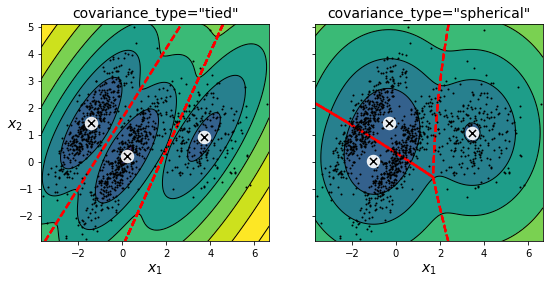

In [4]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)
    
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

plt.show()

<h2>Anomaly Detection usando Gaussian Mixtures. Seleccionando el número de Clusters.</h2>

Gaussian Mixtures se utiliza para la detección de atípicos (outliers), considerando que cualquier instancia ubicada en una zona de baja densidad es un atípico. Simplemente se ha de definir un threshold de densidad a usar.

Por ejemplo, si utilizas Gaussian Mixtures para detectar productos defectuosos, se debe establecer un threshold y ver qué esta proporcionando. Si se clasifican demasiadas piezas correctas como defectuosas, se puede reducir el threshold. Si, por el contrario, se clasifican demasiadas defectuosas como correctas, se puede subir el threshold. Esto no es mas que el precission/recall tradeoff.

Un concepto parecido es el de novelty detection: es una detección de outliers donde el algoritmo se ha entrenado con un dataset que se asume sin ningún outlier. De hecho, la mayoría de las veces se utiliza el outlier detection para limpiar datasets. Cuando se entrena un Gaussian Mixture se modelizan todos los datos (también los atípicos), lo que puede hacer que algunos atípicos se pasen por normales. Por eso, una forma de limpiar hasta los atípicos mas dificiles es entrenar un outlier detector, pasarlo por el dataset y entrenar otro outlier detector sobre el resultado.

Ejemplo de anomaly detection con los modelos anteriores:

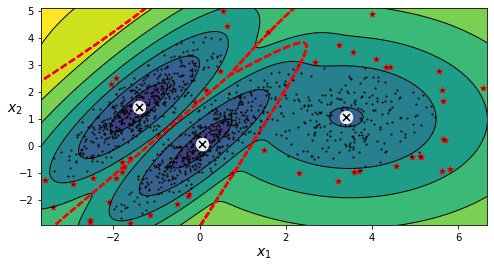

In [5]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

<h3>Seleccionando el número de clusters</h3>

Igual que en el K-Means, en Gaussian Mixture hay que pasar el número de clusters. Con K-Means se podia usar inertia o silhouette score para encontrar el número de clusters, pero con Gaussian no valen porque no son estables cuando los clusters no son esféricos o son de distintos tamaños. 

Para encontrar el número correcto, se buscan los modelos que minimicen "theoretical information criterion" como el Bayesian information criterion (BIC) o el Akaike information criterion (AIC):

    BIC = log(m)*p - 2*log(L^)
    AIC = 2*p - 2*log(L^)
    
Donde m es el número de instancias, p es el número de parámetros aprendidos por el modelo, y L^ es el valor maximizado de la likelihood function del modelo. BIC y AIC penalizan los modelos que tienen muchos parámetros, y recompensan los modelos que ajustan bien los datos. Suelen acabar seleccionando el mismo modelo, pero cuando difieren es porque el modelo seleccionado por BIC tiene menos parámetros y el del AIC ajusta mejor los datos.

Nota: en estadística probability y likelihood no son sinónimos. Probability es cómo de posible es que, conocidos uns parámetros theta, el outcome obtenido sea x; y likelihood es que, conocido un outcome x, cómo de posible es que este sea producido por un conjunto de parámetros theta. Lo relevante aqui es que la PDF (probability distribution function) es una función de x y la likelihood function es una funcion de theta y NO es una función de distribución de probabilidad. Si se integra una función de distribución de probabilidad sobre todos los valores posibles da 1, pero si integras la likelihood el resultado puede ser cualquier valor positivo.

Cuando se coge un dataset, es una tarea comun estimar los valores mas probables para los parámetros del modelo. Estos son los valores que maximizan la likelihood function. Se puede obtener el máximo de la likelihood function (MLE), pero si existe a priori una probability distribution g, es posible maximizar L(theta|x)g(theta) en lugar de solo L (la likelihood), que es el llamado Maximum a-posteriori estimation (MAP) y es una versión regularizada del MLE.

Por último, añadir que es equivalente maximizar la función likelihood o su logaritmo, y suele ser más facil de maximizar el logaritmo ya que es estrictamente creciente y tiene la propiedad log(a*b)=log(a)+log(b)

Una vez se ha estimado el theta que maximiza la función likelihood, se puede computar L^=L(theta,X) que es el valor usado para AIC y BIC. En Sklearn es muy sencillo:

El BIC es:  8189.74345832983
El AIC es:  8102.518178214792


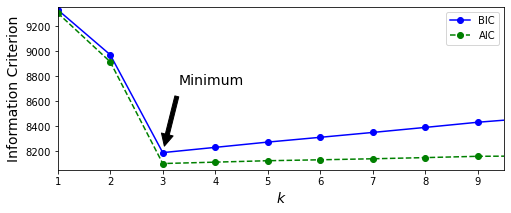

El mejor número de clusters para ambos es:  3


In [9]:
print('El BIC es: ',gm.bic(X))
print('El AIC es: ',gm.aic(X))

# Ejemplo gráfico:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

print('El mejor número de clusters para ambos es: ',bics.index(min(bics))+1)

<h2>Bayesian Gaussian Mixture</h2>

En lugar de intentar obtener de forma manual el número óptimo de clusters, se puede usar la clase BayesianGaussianMixture, que es capaz de asignar 0 (o casi 0) de peso a los clusters innecesarios. El único "inconveniente" es que esta clase precisa de cierto conocimiento previo sobre el problema, pero simplemente con asignar el hiperparámetro n_components a un valor mayor que el número óptimo de clusters ya el algoritmo eliminará los clusters innecesarios de forma automática.

Un ejemplo de Sklearn:

Los pesos de los cluster son:  [0.4  0.21 0.4  0.   0.   0.   0.   0.   0.   0.  ]


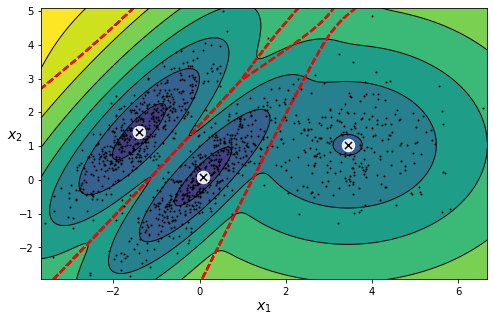

In [12]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
print('Los pesos de los cluster son: ',np.round(bgm.weights_,2))


plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

El algoritmo detecta que sólo hacen falta 3 clusters. En este algoritmo los parámetros del cluster no son parámetros fijos del modelo, si no variables que se inicializan de forma random (como el asignar los clusters).

Es posible informar al algoritmo sobre cierto conocimiento de las variables (a partir de una distribución de probabilidad p(z) llamada "prior"). Por ejemplo, si pensamos que los clusters son poco densos (o al revés) se puede usar el hiperparámetro weight_concentration_prior. Ejemplo:

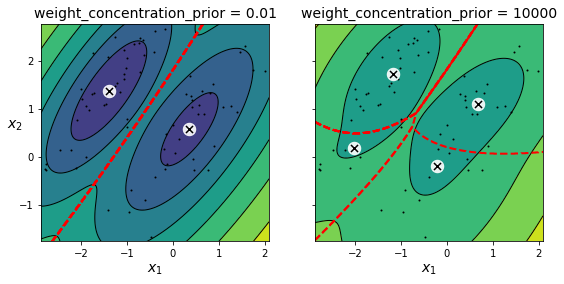

In [13]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])


plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

plt.show()

El teorema de Bayes nos da la posterior distribution p(z|X), que es como se actualiza la distribución de probabilidad sobre las variables que observamos en el dataset X:

    p(z|X) = p(X|z)*p(z)/p(X)
    
Lo malo es que en un Gaussian Mixture el denominador p(X) no tiene solución, por lo que se debe integrar sobre todos los valores posibles de z. Esto es considerar todas las combinaciones posibles de parámetros y asignaciones de clusters. 

Este es uno de los problemas centrales de la estadística Bayesiana, y existen distintas formas de intentar solventarlo. Una de ellas es la variational inference, que coge una familia de distribuciones q(z,lambda) con sus propios parámetros variacionales lambda, y los optimiza para hacer a q(z) una buena aproximación de p(z|X) minimizando KL divergence de q(z) y p(z|X), denominada D_KL(q||p). Minimizar la KL divergence es minimizar el ELBO, como se deriva del siguiente desarrollo:

    D_KL(q||p) = E_q[log (q(z)/p(z|X)] = E_q[log (q(z)) - log(p(z|X))] = E_q[log (q(z)) - log(p(z,X)/p(X))] =
    = E_q[log (q(z)) - log(p(z,X)) + log(p(X))] = E_q[log (q(z))] - E_q[log(p(z,X))] + E_q[log(p(X))] = 
    = E_q[log(p(X))] - (E_q[log(p(z,X))] - E_q[log (q(z))]) = log(p(X)) - ELBO
    
Existen distintas técnicas para maximizar el ELBO. En mean field variational inference es necesario seleccionar la familia de distribuciones q(z,lambda) y el prior p(z) con cuidado para simplificar el ELBO de forma que sea computable. No existe una forma genérica de hacer esto, hay que tener idea feliz matemática.

Una aproximación más simple para maximizar el ELBO es la llamada black box stochastic variational inference (BBSVI). En cada iteración se calculan unos ejemplos y traza el gradiente de ELBO con respecto a los parámetros lambda. Esto hace posible usar Bayesian inference con cualquier modelo si es diferenciable, incluso con Deep Neural Networks (se llama Bayesian Deep Learning).

Por último, los Gaussian Mixtures son malos para trabajar con datasets que no sean elipsoidales, por ejemplo en el cluster de moons que usabamos antes pasa esto:

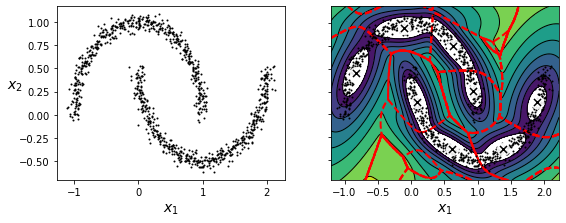

In [16]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

plt.show()

<h2>Otros algoritmos de Anomaly Detection y Novelty Detection</h2>

Existen otros algoritmos de Anomaly y Novelty Detection en Sklearn:

    - Fast-MCD (minimun covariance determinant), implementado en la clase EllipticEnvelope: es muy útil para detección de outliers y limpieza de datasets. Asume que las normal instances son generadas de una única distribución Gaussiana, pero tambiñen que el dataset está "contaminado" con atípicos que no se generan con esta distribución. Cuando estia los parámetros de la distribución Gaussiana ignora las instancias que es más probable que sean outliers. Esto da una mejor estimación de los contornos, y ayuda a identificar mejor los atípicos.
    - Isolation forest: es un algoritmo de detección de outliers muy eficiente, sobre todo en datasets de dimensionalidad alta. El algoritmo genera un Random Forest en el que cada árbol crece de forma aleatoria: en cada nodo selecciona una feature de forma aleatoria, coge un threshold de forma random (entre el max y el min valor) y splitea el dataset en 2. Así corta el dataset en subsets hasta que todas las instances acaban aisladas del resto. Un atípico es aquel que acaba muy lejos del resto, así que en promedio tiende a quedar aislado en menos nodos que los no-atípicos.
    - Local outlier factor (LOF): bueno para detección de atípicos. Compara la densidad de instances cerca de una instance dada con la densidad cerca de sus neighbors. Un atípico es el que está más aislado que sus neighbors.
    - One-class SVM: es bueno para novelty detection. Por recordar, un clasificador kernelized SVM separa en dos clases, primero mapeando todas las instances a un espacio de mayor dimensión, y después separando las dos clases usando un linear SVM en ese espacio de mas dimensiones. En el caso de novelty detection solo tenemos una clase de instances, por lo que el algoritmo intenta separar las instances de una misma clase. En el espacio original esto corresponde a encontrar la minima región que englobe todas las instances. Si una nueva instance no cae en esta región será un atípico. Sólo existen unos pocos hiperparámetros: los tñipicos de un kernelized SVM y un hiperparámetro margin que define la probabilidad de que una instance esté incorrectamente considerada como novel cuando es normal. Este algoritmo funciona muy bien, sobre todo en datasets de muchas dimensiones, pero como todos los SVMs escala fatal con los datasets grandes.